# Evaluate Machine teaching approach



In [3]:
#Setup
from fastai import *          # Quick accesss to most common functionality
from fastai.tabular import *  # Quick accesss to tabular functionality     # Access to example data provided with fastai
from fastai.vision import *
#import commuter
#import sys
sys.path.append("../code") # go to parent dir
from commuter import *
PATH="../data/"
dep_var = 'journey'
cat_names = ["detectedActivity","weekday"]
cont_names =["geoHash","minuteOfDay"]
procs = [FillMissing, Categorify, Normalize]
# Uncomment active user
#user = "tnK534JMwwfhvUEycn69HPbhqkt2" #Maria
#user = "ehaBtfOPDNZjzy1MEvjQmGo4Zv12" #Andrea
user = "hCWCulj7M1aMVyd0Fm0Eqrv8q1Q2" #Bjorn

def evaluate_teaching_daily(learner,testset):
    result = []
    oldDayNumber=-1
    daySet = DataFrame(testset[0:0]) #copy structure:
    for row in testset.itertuples():
        if oldDayNumber != row[4] or row[0]+1==len(testset): #A new day!   
            if (row[0]+1==len(testset)):   ##if last line add that row
                daySet = daySet.append(testset.iloc[row[0]]) 
            if len(daySet)>0:
                accuracy = round(predict_journeys(learner,daySet),3)
                result.append([accuracy,oldDayNumber])
                daySet = daySet.iloc[0:0]
                daySet =daySet.append(testset.iloc[row[0]])
            else: ##it is first row or no teaching data exists(Cold start) so no training is possible
                daySet = daySet.append(testset.iloc[row[0]])
            #shamecode below.....
            #Adds extra rows with 0 accuracy if there are days with no data.
            emptyDays = 0
            if oldDayNumber == 6: #End of week
                emptyDays = row[4]
            if row[4]-oldDayNumber>1 and oldDayNumber != -1:
                emptyDays = row[4]-oldDayNumber-1
            for i in range(0,emptyDays):
                result.append([0,(i+oldDayNumber)%6])  
            oldDayNumber = row[4]
        else: # same old day add the row  
            daySet = daySet.append(testset.iloc[row[0]])
    return (result)

In [4]:
%run ../code/commuter.py

### Accuracy daily during the initial 14 days of use.

epoch,train_loss,valid_loss,accuracy
1,1.049259,1.310985,0.530000
2,0.638759,0.771304,0.890000
3,0.418134,0.352246,1.000000
4,0.286062,0.120307,1.000000
5,0.202973,0.048640,1.000000
6,0.149556,0.028427,1.000000
7,0.113468,0.023458,1.000000


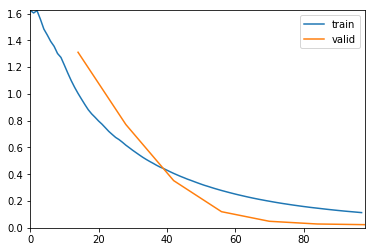

CPU times: user 1.91 s, sys: 680 ms, total: 2.59 s
Wall time: 3.25 s


In [18]:
#%%capture
teachingSet = pd.read_csv(PATH+user+"_teaching_set.csv")
teachingSet= make_shure_we_got_enough_rows(teachingSet)
valid_idx = list(np.random.randint(0,len(teachingSet),int(len(teachingSet)*0.1)))
data = (TabularList.from_df(teachingSet, path=user, cat_names=cat_names, cont_names=cont_names, procs=procs)
                .split_by_idx(valid_idx)
                .label_from_df(cols=dep_var)
                .databunch())
learner=tabular_learner(data, layers=[200,100], metrics=accuracy,callback_fns=ShowGraph)
%time learner.fit_one_cycle(7)


In [19]:
testSet = pd.read_csv(PATH+user+"_test.csv")
result = predict_journeys(learner,testSet)
print("Test set accuracy: "+str(result))

Test set accuracy: 0.44813278008298757


In [5]:
the14FirstDays = pd.read_csv(PATH+user+"_start14days.csv")
result = evaluate_teaching_daily(learner,the14FirstDays)
print(result)
save_results(user+"_result_teaching_14days.csv",result)

[[1.0, 6], [0, 0], [0, 1], [0.444, 2], [0.429, 3], [0.636, 4], [0.8, 5], [1.0, 6], [0, 0], [0, 1], [0.286, 2], [0.6, 3], [0.273, 4], [0.0, 5]]


### Iterative training daily during the initial 14 days of use, a teaching set is added to the training data.
Here we add an idealised teaching set in the beginning of our dataset. Then we start training from day 0 using only the data in the teachingset and contiuing as in the section above.
Teachingset:

Andrea:
[Verbose](https://github.com/k3larra/commuter/blob/master/data/ehaBtfOPDNZjzy1MEvjQmGo4Zv12_teaching_set.csv)
[Minimal](../commuter/data/ehaBtfOPDNZjzy1MEvjQmGo4Zv12_teaching_set_minimal.csv)

Björn:
[Verbose](https://github.com/k3larra/commuter/blob/master/data/hCWCulj7M1aMVyd0Fm0Eqrv8q1Q2_teaching_set.csv)
[Minimal](../commuter/data/hCWCulj7M1aMVyd0Fm0Eqrv8q1Q2_teaching_set_minimal.csv)

Maria:
[Verbose](https://github.com/k3larra/commuter/blob/master/data/tnK534JMwwfhvUEycn69HPbhqkt2_teaching_set.csv)
[Minimal](../commuter/data/tnK534JMwwfhvUEycn69HPbhqkt2_teaching_set_minimal.csv)

### Show results
Prints results from training done in the cells above.

[ 1  2  3  4  5  6  7  8  9 10 11 12 13 14]
[6. 0. 1. 2. 3. 4. 5. 6. 0. 1. 2. 3. 4. 5.]


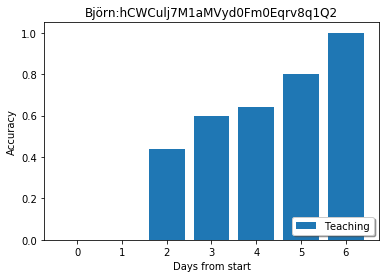

In [19]:
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter, MaxNLocator
#import pandas as pd
personas = pd.read_csv("../data/personas.csv")
#Uncomment to look at individual result for other users that the default declared above.
#user = "tnK534JMwwfhvUEycn69HPbhqkt2" #Maria
#user = "ehaBtfOPDNZjzy1MEvjQmGo4Zv12" #Andrea
#user = "hCWCulj7M1aMVyd0Fm0Eqrv8q1Q2" #Bjorn
personaname = personas.loc[personas['id']==user]
teaching_ax0= pd.read_csv("saved/"+user+"_result_teaching_14days.csv",header=None).values
#teaching_ax0 = pd.read_csv("saved/Iterative_time_teach"+user+".csv",header=None).values
#teaching_min_ax0 = pd.read_csv("saved/Iterative_time_teach_minimal"+user+".csv",header=None).values
#supervised_min_ax0 = pd.read_csv("saved/Iterative_time_supervised"+user+".csv",header=None).values
fig, ax0 = plt.subplots()
ind = np.arange(1,15)
print(ind)
print(teaching_ax0[:,1])

ax0.set_title(personaname ['name'].iloc[0]+":"+user)
#ax0.bar(teaching_ax0[:,0],label='Teaching larger set')
ax0.bar(teaching_ax0[:,1],teaching_ax0[:,0],label='Teaching')
# ax0.plot(teaching_ax0[:,2],label='Teaching')
# ax0.plot(teaching_min_ax0[:,2],label='Teaching using minimal data')
# ax0.plot(supervised_min_ax0[:,2],label='Pretrained model')
# plt.xticks(ind)
plt.xlabel('Days from start')
plt.ylabel('Accuracy')
legend = ax0.legend(loc='lower right', shadow=True, fontsize='medium')
plt.show()

### Evaluate on test set
Evaluate using the test set on a trained "learner"*

#### Predict on individual journey